# CORD-19 Software classification

This notebook is designated to classify software mentions based on the CORD19 dataset from:

Wade, Alex D.; Williams, Ivana (2021), CORD-19 Software Mentions, Dryad, Dataset, https://doi.org/10.5061/dryad.vmcvdncs0

First, relevant packages must be imported into the notebook.

In [1]:
import numpy as np
import pandas as pd
import csv
import ast
import collections
import matplotlib.pyplot as plt
import Levenshtein as lev
from fuzzywuzzy import fuzz 
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import json

The outcome "df_software_mentions" of the notebook "CORD-19-software-counting-cs5099.ipynb" will be used for classification purposes. Therefore, the notebook reads the content from the file "software_mentions.pkl".

In [2]:
df_software_mentions = pd.read_pickle('software_mentions_CS5099.pkl')
df_software_mentions

,Software,Matches,Change
0,R,13163,0
1,SPSS,11290,0
2,GRAPHPAD PRISM,8499,0
4,BLAST,6711,+1
3,EXCEL,4319,-1
...,...,...,...
8611,7VINCUT,9,+1448
8856,6GCVAE,9,+1692
9085,4D,9,+1920
9347,3DRNA,9,+2181


Shift the focus to the column software and create a column for classification.

In [3]:
df_software = df_software_mentions.drop('Change', 1)
df_software = df_software.reset_index()
df_software = df_software.drop('index', 1)
df_software['Classification'] = "Unclassified"
df_software

,Software,Matches,Classification
0,R,13163,Unclassified
1,SPSS,11290,Unclassified
2,GRAPHPAD PRISM,8499,Unclassified
3,BLAST,6711,Unclassified
4,EXCEL,4319,Unclassified
...,...,...,...
7163,7VINCUT,9,Unclassified
7164,6GCVAE,9,Unclassified
7165,4D,9,Unclassified
7166,3DRNA,9,Unclassified


Subsequently, the next cell outputs software mentions which must be manually copied to the file "software_categories_CS5099.csv" for classification purposes.

In [4]:
result = df_software.to_json(orient='records')
parsed = json.loads(result)
software_json = json.dumps(parsed, indent=4) 
df_read_json = pd.read_json(software_json)
print(df_read_json.to_string()) 

                                         Software  Matches Classification
0                                               R    13163   Unclassified
1                                            SPSS    11290   Unclassified
2                                  GRAPHPAD PRISM     8499   Unclassified
3                                           BLAST     6711   Unclassified
4                                           EXCEL     4319   Unclassified
5                                           STATA     4048   Unclassified
6                                            MEGA     3428   Unclassified
7                                             SAS     3399   Unclassified
8                                          IMAGEJ     2779   Unclassified
9                                          MATLAB     2710   Unclassified
10                                 GOOGLE SCHOLAR     2485   Unclassified
11                                            NET     2411   Unclassified
12                                    

Next, the file "software_categories_CS5099.csv" is read from the directory and presented. 

In [5]:
Categories_CSV = pd.read_csv('software_categories_CS5099.csv')
Categories_CSV

,Statistics,Bioinformatics,Communication,BibliographyServices,OperatingSystems,ProgrammingLanguage,Uncertain
0,R,BLAST,REDCAP,GOOGLE SCHOLAR,IOS,MATLAB,EXCEL
1,SPSS,PYMOL,SKYPE,SCOPUS,LINUX,NET,MEGA
2,STATA,CHIMERA,QUALTRICS,GISAID,WINDOWS,PYTHON,MUSCLE
3,SAS,FLOWJO,GITHUB,GOOGLE TRENDS,MS,BERT,SWISS
4,NVIVO,ENSEMBL,REDDIT,XGBOOST,MOE,TENSORFLOW,PHENIX
5,SEURAT,BEAST,FACETIME,FASTTEXT,ROSETTA,SIMPLOT,ONE
6,MEDCALC,MAFFT,SURVEYMONKEY,CHEMBL,NaN,SCIKIT,MODEL
7,GRAPHPAD PRISM,CYTOSCAPE,NaN,NaN,NaN,WORD2VEC,LEARN
8,GGPLOT2,GROMACS,NaN,NaN,NaN,SPARQL,CT
9,STATISTICAL PACKAGE FOR THE SOCIAL SCIENCES,GENEIOUS,NaN,NaN,NaN,OPENMP,ARCGIS


In [6]:
def get_category(mention):
    """
    Function receiving a software mention a returning its category. When no category is found 'None' is returned.
    The function works dynamically to the entries of the Categoies_CSV.
    """
    category_holder = "None"
    len_categories = len(Categories_CSV.columns)
    i = 0
    while i < len_categories: 
        column_holder = Categories_CSV.columns[i]
        if(any(Categories_CSV[column_holder] == mention) == True):
            return Categories_CSV.columns[i]
        i = i + 1

Each software mention must be assigned to a category. 

In [7]:
%%time
dict_categories = {}
for i, row in df_software.iterrows():
    row.Classification = get_category(row.Matches)
    dict_categories[i] = get_category(row.Software)
df_software.Classification = dict_categories.values()
df_software.head(5)

Wall time: 36.1 s


,Software,Matches,Classification
0,R,13163,Statistics
1,SPSS,11290,Statistics
2,GRAPHPAD PRISM,8499,Statistics
3,BLAST,6711,Bioinformatics
4,EXCEL,4319,Uncertain


Consequently, the software categories are summed up and presented. 

In [8]:
len_df_classification_holder = len(df_software)
classification_series = df_software['Classification'].value_counts()
len_classification_series = len(classification_series.index)

df_total_matches = pd.DataFrame(columns=['Matches'], index = classification_series.index )
df_total_matches['Matches'] = 0

i = 0
while i < len_classification_series:
    x = 0
    while x < len_df_classification_holder:
        if df_software['Classification'][x] == classification_series.index[i]:
            df_total_matches['Matches'][classification_series.index[i]] = df_total_matches['Matches'][classification_series.index[i]] + df_software['Matches'][x]
        x = x + 1
    i = i + 1

df_total_matches.sort_values(by="Matches", ascending=False)

,Matches
Statistics,43154
Bioinformatics,26637
Uncertain,20157
ProgrammingLanguage,11711
BibliographyServices,8866
Communication,4672
OperatingSystems,3675


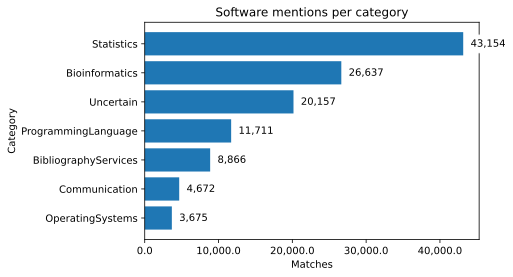

In [13]:
df_total_matches_sorted = df_total_matches.sort_values(by="Matches", ascending=True)

x = df_total_matches_sorted['Matches'].index
y = df_total_matches_sorted['Matches'].values

fig, ax = plt.subplots()
plt.barh(x, y)

# x axis with commata 
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))

# labelling the bars
for i, v in enumerate(y):
    ax.text(v + 1000, i - 0.1, str(f'{v:,}'), color='black', backgroundcolor='white')

plt.title("Software mentions per category")
plt.xlabel("Matches")
plt.ylabel("Category")
%config InlineBackend.figure_format = 'svg'
plt.savefig('software_mentions_plot.svg',bbox_inches='tight', dpi=400)  

plt.show()